<a id="section-one"></a>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #F39B9B;
            background-color:#F39B9B;
            overflow:hidden;
            font-weight:500">Introduction</div>

## Overview and Table of Contents

In this notebook I will discuss using XGBoost and Optuna for time series forecasting. However, I will begin with a simple linear trend model and build up to more complex approaches. I will also illustrate different feature engineering strategies ranging from indicator features to lagging.

* [Introduction](#section-one)
* [Data](#section-two)
* [Linear Trend Model](#section-three)
* [Feature Engineering](#section-four)
* [Linear Model + More Features](#section-five)
* [XGBoost and Optuna](#section-six)
* [Trend Model + XGBoost + Optuna](#section-seven)
* [More Feature Engineering: Lagged Features (Lagging)](#section-eight)
* [XGBoost + Optuna with Lagged Features](#section-nine)
* [Conclusion](#section-ten)

## Set-up

In [1]:
# Installs
!pip install polars
!pip install lets-plot

# Imports
import polars as pl
import xgboost as xgb
import numpy as np
import optuna
import math
import statistics as stat

from lets_plot import *
from lets_plot.mapping import as_discrete
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import plotly
import plotly.figure_factory as ff

LetsPlot.setup_html()
plotly.offline.init_notebook_mode(connected = True)

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


<a id="section-two"></a>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #F39B9B;
            background-color:#F39B9B;
            overflow:hidden;
            font-weight:500">Data</div>

## Data Importing

The data contain vehicle traffic across time at four junctions. In this notebook I'll only focus on a single time series from the first junction. After importing the data I added a time index column that is simply a sequence of integers *(0,1,2,....N)*.

In [2]:
df = pl.read_csv("../input/traffic-prediction-dataset/traffic.csv", parse_dates = True).drop("ID")
df = df.filter(pl.col("Junction") == 1) # Take only the first junction
df = df.with_row_count(name = "Time_index", offset = 0) # add time index column
df.head()

Time_index,DateTime,Junction,Vehicles
u32,datetime[μs],i64,i64
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


## Splitting

For simplicity I will make one training/validation split. The validation period will be June 2017 - the last month of vehicle traffic present in the data.

In [3]:
# Split into training and validation sets
df_train = df.filter(pl.col("DateTime") < pl.datetime(2017, 6, 1))
df_valid = df.filter(pl.col("DateTime") >= pl.datetime(2017, 6, 1))

## Training Set EDA

Below is a plot of the training data. A few things are evident from the plot:
1. Vehicle traffic increases across time (upward trend)
2. The variation in traffic increases across time (non-constant variance)

In [4]:
# Initializing stuff
j1_color = "#EC7F6E"
linesize = 1

# Time series plot for each junction's training set
plt_ts = \
    ggplot(df_train)+\
    geom_line(aes(x = "DateTime", y = "Vehicles"), 
              color = j1_color, sampling = "none", size = linesize)+\
    scale_x_datetime(format = "%b %Y")+\
    theme_minimal2()+\
    theme(plot_title = element_text(hjust = 0.5, face = 'bold'))+\
    labs(x = "Date", y = "Vehicles", title = "Junction 1 Training Data")

ts_bunch = GGBunch()
ts_bunch.add_plot(plt_ts, 0, 0, 850, 300)
ts_bunch

<a id="section-three"></a>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #F39B9B;
            background-color:#F39B9B;
            overflow:hidden;
            font-weight:500">Linear Trend Model</div>

A simple strategy to forecasting vehicle traffic would be to try and capture the trend alone. This can be accomplished using a linear regression model where the only feature is the time index *(0, 1, 2, ..... N)*. The plot below shows the predictions on the validation set. Indeed, the model captured the general trend.

In [5]:
# Pre-process data for the regression model
xtrain = df_train.get_column("Time_index").to_numpy()
xvalid = df_valid.get_column("Time_index").to_numpy()

xtrain = xtrain.reshape(-1,1)
xvalid = xvalid.reshape(-1,1)

ytrain = df_train.get_column("Vehicles").to_numpy()
yvalid = df_valid.get_column("Vehicles").to_numpy()

# Training 
trend_model = LinearRegression().fit(xtrain, ytrain)

# Predicting
trend_preds_valid = trend_model.predict(xvalid)

# Getting the RMSE
print("--------------------------------------------------------------")
print("Trend model validation set RMSE:", math.sqrt(mean_squared_error(yvalid, trend_preds_valid)))
print("--------------------------------------------------------------")

--------------------------------------------------------------
Trend model validation set RMSE: 27.24957995600769
--------------------------------------------------------------


In [6]:
# Initializing a color
true_values_color = "gray"
trend_model_color = '#C754F0'

# Getting the validation data for the plot
df_labels = pl.DataFrame(
    {'DateTime': df_valid.get_column("DateTime"), 
     'Vehicles': df_valid.get_column("Vehicles"), 
     'Group': ["Label"]*len(df_valid)}
)

df_preds = pl.DataFrame(
    {'DateTime_preds': df_valid.get_column("DateTime"), 
     'Vehicles_preds': trend_preds_valid, 
     'Group_preds': ["Predictions"]*len(df_valid)}
)

df_trend_results_valid = (
    pl.concat([df_labels, df_preds], how = 'horizontal')
    .with_columns(
        (pl.lit("True Values").alias("Group_label")),
        (pl.lit("Predictions").alias("Group_pred")))
)

# Plotting the predictions on the validation set
plt_reg_valid = \
    ggplot(df_trend_results_valid)+\
    geom_line(aes(x = "DateTime", y = "Vehicles", color = "Group_label"), 
              sampling = "none", size = linesize, show_legend = True)+\
    geom_line(aes(x = "DateTime", y = "Vehicles_preds", color = "Group_pred"), 
              sampling = "none", size = linesize, show_legend = True)+\
    scale_color_manual(values = [true_values_color, trend_model_color])+\
    scale_x_datetime(format = "%Y-%m-%d")+\
    scale_y_continuous(limits = [20, 145])+\
    theme_minimal2()+\
    theme(plot_title = element_text(hjust = 0.5, face = 'bold'),
         legend_title = element_blank())+\
    labs(x = "Date", y = "Vehicles", title = "Linear Trend Model: Validation Set Predictions")

reg_bunch = GGBunch()
reg_bunch.add_plot(plt_reg_valid, 0, 0, 850, 300)
reg_bunch

<a id="section-four"></a>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #F39B9B;
            background-color:#F39B9B;
            overflow:hidden;
            font-weight:500">Feature Engineering</div>

## Creating New Features

One way to improve the trend model is to add more features. Below I added the following indcator features:
1. Year
2. Month
3. Date (within a month)
4. Day of the week
5. Hour

In [7]:
# Features on the training set
df_train = df_train.with_columns(pl.col("DateTime").dt.year().alias("Year"))
df_train = df_train.with_columns(pl.col("DateTime").dt.month().alias("Month"))
df_train = df_train.with_columns(pl.col("DateTime").dt.day().alias("Day_month"))
df_train = df_train.with_columns(pl.col("DateTime").dt.weekday().alias("Day_week"))
df_train = df_train.with_columns(pl.col("DateTime").dt.hour().alias("Hour"))

# Features on the validation set
df_valid = df_valid.with_columns(pl.col("DateTime").dt.year().alias("Year"))
df_valid = df_valid.with_columns(pl.col("DateTime").dt.month().alias("Month"))
df_valid = df_valid.with_columns(pl.col("DateTime").dt.day().alias("Day_month"))
df_valid = df_valid.with_columns(pl.col("DateTime").dt.weekday().alias("Day_week"))
df_valid = df_valid.with_columns(pl.col("DateTime").dt.hour().alias("Hour"))

print(df_train.head())
print(df_valid.head())

shape: (5, 9)
┌────────────┬──────────────┬──────────┬──────────┬─────┬───────┬───────────┬──────────┬──────┐
│ Time_index ┆ DateTime     ┆ Junction ┆ Vehicles ┆ ... ┆ Month ┆ Day_month ┆ Day_week ┆ Hour │
│ ---        ┆ ---          ┆ ---      ┆ ---      ┆     ┆ ---   ┆ ---       ┆ ---      ┆ ---  │
│ u32        ┆ datetime[μs] ┆ i64      ┆ i64      ┆     ┆ u32   ┆ u32       ┆ u32      ┆ u32  │
╞════════════╪══════════════╪══════════╪══════════╪═════╪═══════╪═══════════╪══════════╪══════╡
│ 0          ┆ 2015-11-01   ┆ 1        ┆ 15       ┆ ... ┆ 11    ┆ 1         ┆ 7        ┆ 0    │
│            ┆ 00:00:00     ┆          ┆          ┆     ┆       ┆           ┆          ┆      │
│ 1          ┆ 2015-11-01   ┆ 1        ┆ 13       ┆ ... ┆ 11    ┆ 1         ┆ 7        ┆ 1    │
│            ┆ 01:00:00     ┆          ┆          ┆     ┆       ┆           ┆          ┆      │
│ 2          ┆ 2015-11-01   ┆ 1        ┆ 10       ┆ ... ┆ 11    ┆ 1         ┆ 7        ┆ 2    │
│            ┆ 02:00:00   

<a id="section-five"></a>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #F39B9B;
            background-color:#F39B9B;
            overflow:hidden;
            font-weight:500">Linear Model + More Features</div>

Next, I included the new features in a linear model. As shown in the plot, the model now captures some of the cyclical elements in the data. However, there is still room for improvement.

In [8]:
# Pre-process data for the regression model
xtrain = df_train.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()
xvalid = df_valid.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()

ytrain = df_train.get_column("Vehicles").to_numpy()
yvalid = df_valid.get_column("Vehicles").to_numpy()

# Training 
reg_model = LinearRegression().fit(xtrain, ytrain)

# Predicting
reg_preds_valid = reg_model.predict(xvalid)

# Getting the RMSE
print("---------------------------------------------------------------------------")
print("Linear model + more features validation set RMSE:", 
      math.sqrt(mean_squared_error(yvalid, reg_preds_valid)))
print("----------------------------------------------------------------------------")

---------------------------------------------------------------------------
Linear model + more features validation set RMSE: 21.36780895656419
----------------------------------------------------------------------------


In [9]:
# Initializing a color
reg_model_color = '#1CA699'

# Getting the validation data for the plot
df_preds = pl.DataFrame(
    {'DateTime_preds': df_valid.get_column("DateTime"), 
     'Vehicles_preds': reg_preds_valid, 
     'Group_preds': ["Predictions"]*len(df_valid)}
)

df_reg_results_valid = (
    pl.concat([df_labels, df_preds], how = 'horizontal')
    .with_columns(
        (pl.lit("True Values").alias("Group_label")),
        (pl.lit("Predictions").alias("Group_pred")))
)

# Plotting the predictions on the validation set
plt_reg_valid = \
    ggplot(df_reg_results_valid)+\
    geom_line(aes(x = "DateTime", y = "Vehicles", color = "Group_label"), 
              sampling = "none", size = linesize, show_legend = True)+\
    geom_line(aes(x = "DateTime", y = "Vehicles_preds", color = "Group_pred"), 
              sampling = "none", size = linesize, show_legend = True)+\
    scale_color_manual(values = [true_values_color, reg_model_color])+\
    scale_x_datetime(format = "%Y-%m-%d")+\
    scale_y_continuous(limits = [20, 145])+\
    theme_minimal2()+\
    theme(plot_title = element_text(hjust = 0.5, face = 'bold'),
         legend_title = element_blank())+\
    labs(x = "Date", y = "Vehicles", title = "Linear Model: Validation Set Predictions")

reg_bunch = GGBunch()
reg_bunch.add_plot(plt_reg_valid, 0, 0, 850, 300)
reg_bunch

<a id="section-six"></a>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #F39B9B;
            background-color:#F39B9B;
            overflow:hidden;
            font-weight:500">XGBoost with Optuna</div>

XGBoost is another algorithm that can be used to make time series forecasts. Below I use Optuna to automatically tune several of XGBoost's hyperparameters. The training set for this model includes the new features. As shown in the plot below, the XGBoost model makes much more accurate predictions than the linear model even though they used the same features.

**NOTE:** Performance could likely be improved further simply by letting Optuna run for longer.

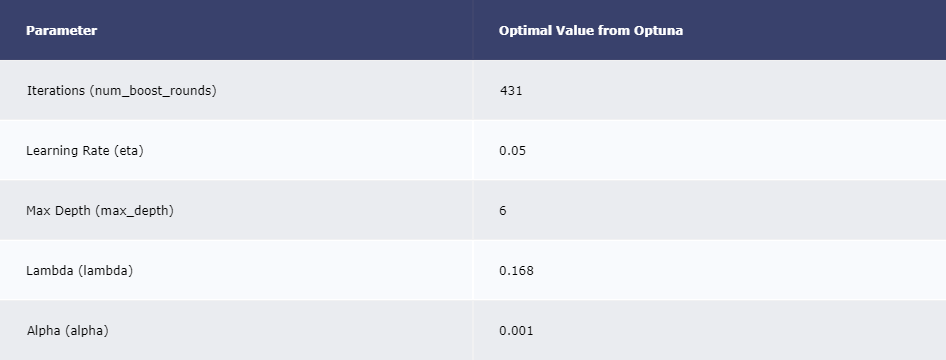

In [10]:
# Suppress optuna log messages
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# Optuna objective function
def objective_xgb(trial):
    """
    Optuna objective function. Returns
    the RMSE for an XGBoost model
    
    Assumes the training data are 
    polars data frames
    """
    # Get data for the XGBoost model
    xtrain = df_train.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()
    xvalid = df_valid.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()

    ytrain = df_train.get_column("Vehicles").to_numpy()
    yvalid = df_valid.get_column("Vehicles").to_numpy()
    
    dmat_train = xgb.DMatrix(xtrain, label = ytrain)
    dmat_valid = xgb.DMatrix(xvalid, label = yvalid)
    
    # Suggest hyperparameters for XGBoost
    params = {'objective': 'reg:squarederror',
              'eval_metric': 'rmse',
              'seed': 19970507,
              'eta': trial.suggest_float("eta", 1e-2, 0.25, log = True),
              'max_depth': trial.suggest_int("max_depth", 1, 7),
              'lambda': trial.suggest_float("lambda", 1e-8, 100.0, log = True),
              'alpha': trial.suggest_float("alpha", 1e-8, 100.0, log = True),
             }
    
    # To evaluate training progress (set verbose_eval = True)
    watchlist = [(dmat_train, 'train'), (dmat_valid, 'eval')]
    
    # Train the XGBoost model
    xgb_model = xgb.train(params, 
                          dtrain = dmat_train, 
                          num_boost_round = trial.suggest_int("num_boost_round", 20, 3000),
                          evals = watchlist,
                          verbose_eval = False)
    
    xgb_preds_valid = xgb_model.predict(dmat_valid) 
    
    # Return the RMSE
    return math.sqrt(mean_squared_error(yvalid, xgb_preds_valid))


# Set up and run the Optuna study
study_xgb = optuna.create_study(direction = 'minimize')
study_xgb.optimize(objective_xgb, n_trials = 10)

# Create a table showing the best parameters
xgb_table = [["Parameter", "Optimal Value from Optuna"],
            ["Iterations (num_boost_rounds)", study_xgb.best_params['num_boost_round']],
            ['Learning Rate (eta)', round(study_xgb.best_params['eta'], 3)],
            ['Max Depth (max_depth)', round(study_xgb.best_params['max_depth'], 3)],
            ['Lambda (lambda)', round(study_xgb.best_params['lambda'], 3)],
            ['Alpha (alpha)', round(study_xgb.best_params['alpha'], 3)]]

ff.create_table(xgb_table)

In [11]:
# Taking the model with the best hyperparameters and testing it
xtrain = df_train.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()
xvalid = df_valid.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()

ytrain = df_train.get_column("Vehicles").to_numpy()
yvalid = df_valid.get_column("Vehicles").to_numpy()
    
dmat_train = xgb.DMatrix(xtrain, label = ytrain)
dmat_valid = xgb.DMatrix(xvalid, label = yvalid)

best_params = {'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'seed': 19970507,
                'eta': study_xgb.best_params['eta'],
                'max_depth': study_xgb.best_params['max_depth'],
                'lambda': study_xgb.best_params['lambda'],
                'alpha': study_xgb.best_params['alpha'],
                 }

xgb_model = xgb.train(best_params, 
                      dtrain = dmat_train, 
                      num_boost_round = study_xgb.best_params['num_boost_round'],
                      verbose_eval = False)

xgb_preds_valid = xgb_model.predict(dmat_valid)

print('----------------------------------------------------------')
print('XGBoost validation set RMSE:', math.sqrt(mean_squared_error(yvalid, xgb_preds_valid)))
print('----------------------------------------------------------')

----------------------------------------------------------
XGBoost validation set RMSE: 7.262893578064327
----------------------------------------------------------


In [12]:
# Initializing a color
xgb_color = '#F78B38'

# Getting the validation data for the plot
df_preds = pl.DataFrame(
    {'DateTime_preds': df_valid.get_column("DateTime"), 
     'Vehicles_preds': xgb_preds_valid, 
     'Group_preds': ["Predictions"]*len(df_valid)}
)

df_xgb_results_valid = (
    pl.concat([df_labels, df_preds], how = 'horizontal')
    .with_columns(
        (pl.lit("True Values").alias("Group_label")),
        (pl.lit("Predictions").alias("Group_pred")))
)

# Plotting the predictions on the validation set
plt_xgb_valid = \
    ggplot(df_xgb_results_valid)+\
    geom_line(aes(x = "DateTime", y = "Vehicles", color = "Group_label"), 
              sampling = "none", size = linesize, show_legend = True)+\
    geom_line(aes(x = "DateTime", y = "Vehicles_preds", color = "Group_pred"), 
              sampling = "none", size = linesize, show_legend = True)+\
    scale_color_manual(values = [true_values_color, xgb_color])+\
    scale_x_datetime(format = "%Y-%m-%d")+\
    scale_y_continuous(limits = [20, 145])+\
    theme_minimal2()+\
    theme(plot_title = element_text(hjust = 0.5, face = 'bold'),
         legend_title = element_blank())+\
    labs(x = "Date", y = "Vehicles", title = "XGBoost: Validation Set Predictions")

xgb_bunch = GGBunch()
xgb_bunch.add_plot(plt_xgb_valid, 0, 0, 850, 300)
xgb_bunch

<a id="section-seven"></a>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #F39B9B;
            background-color:#F39B9B;
            overflow:hidden;
            font-weight:500">Trend Model + XGBoost + Optuna</div>

Another approach is to combine the trend model with XGBoost. One way to combine them is as follows: train the trend model and calculate the residuals, then use the residuals as a target to train the XGBoost model, afterwards add the trend model's predictions with the XGBoost model's predictions to get the final forecast values.

The idea behind this approach is to let the trend model capture, you guessed it, the trend in the data. Then XGBoost is used to predict the errors and capture the non-trend components in the time series. 

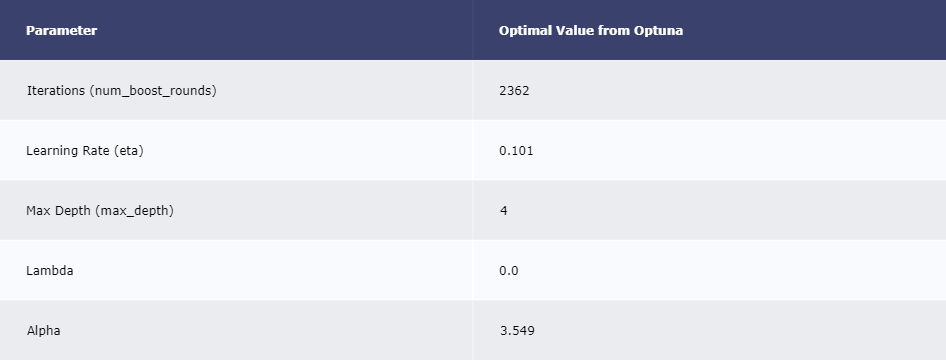

In [13]:
# Suppress optuna log messages
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# Optuna objective function
def objective_trend_xgb(trial):
    
    # Get data for the trend model
    xtrain_reg = df_train.get_column("Time_index").to_numpy()
    xvalid_reg = df_valid.get_column("Time_index").to_numpy()

    xtrain_reg = xtrain_reg.reshape(-1,1)
    xvalid_reg = xvalid_reg.reshape(-1,1)
    
    ytrain = df_train.get_column("Vehicles").to_numpy()
    yvalid = df_valid.get_column("Vehicles").to_numpy()
    
    # Train and predict w/ the trend model
    reg_model = LinearRegression().fit(xtrain_reg, ytrain)

    # Predicting
    reg_preds_train = reg_model.predict(xtrain_reg)
    reg_preds_valid = reg_model.predict(xvalid_reg)
    
    # Calculate the residuals
    reg_resids_train = (ytrain - reg_preds_train)
    reg_resids_valid = (yvalid - reg_preds_valid)
    
    # Get the data for the XGB model
    xtrain_xgb = df_train.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()
    xvalid_xgb = df_valid.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()
    
    dmat_train = xgb.DMatrix(xtrain_xgb, label = reg_resids_train)
    dmat_valid = xgb.DMatrix(xvalid_xgb, label = reg_resids_valid)
    
    # Suggest hyperparameters
    params = {'objective': 'reg:squarederror',
              'eval_metric': 'rmse',
              'seed': 19970507,
              'eta': trial.suggest_float("eta", 1e-2, 0.25, log = True),
              'max_depth': trial.suggest_int("max_depth", 1, 7),
              'lambda': trial.suggest_float("lambda", 1e-8, 100.0, log = True),
              'alpha': trial.suggest_float("alpha", 1e-8, 100.0, log = True),
             }
    
    # To evaluate training progress (set verbose_eval = True)
    watchlist = [(dmat_train, 'train'), (dmat_valid, 'eval')]
    
    # Train and predict w/ the XGBoost model
    xgb_model = xgb.train(params, 
                          dtrain = dmat_train, 
                          num_boost_round = trial.suggest_int("num_boost_round", 20, 3000),
                          evals = watchlist,
                          verbose_eval = False)
    
    xgb_preds_valid = xgb_model.predict(dmat_valid) 
    
    # Sum the final predictions
    trend_xgb_preds_valid = (reg_preds_valid + xgb_preds_valid)
    
    # Return the RMSE
    return math.sqrt(mean_squared_error(yvalid,  trend_xgb_preds_valid))
    

# Set up and run the Optuna study
study_trend_xgb = optuna.create_study(direction = 'minimize')
study_trend_xgb.optimize(objective_trend_xgb, n_trials = 10)

# Create a table showing the best parameters
trend_xgb_table = [["Parameter", "Optimal Value from Optuna"],
                  ["Iterations (num_boost_rounds)", study_trend_xgb.best_params['num_boost_round']],
                  ['Learning Rate (eta)', round(study_trend_xgb.best_params['eta'], 3)],
                  ['Max Depth (max_depth)', round(study_trend_xgb.best_params['max_depth'], 3)],
                  ['Lambda', round(study_trend_xgb.best_params['lambda'], 3)],
                  ['Alpha', round(study_trend_xgb.best_params['alpha'], 3)]]

ff.create_table(trend_xgb_table)

In [14]:
# Taking the model with the best hyperparameters and testing it

# Get data for the trend model
xtrain_reg = df_train.get_column("Time_index").to_numpy()
xvalid_reg = df_valid.get_column("Time_index").to_numpy()

xtrain_reg = xtrain_reg.reshape(-1,1)
xvalid_reg = xvalid_reg.reshape(-1,1)
    
ytrain = df_train.get_column("Vehicles").to_numpy()
yvalid = df_valid.get_column("Vehicles").to_numpy()
    
# Train and predict w/ the trend model
reg_model = LinearRegression().fit(xtrain_reg, ytrain)

# Predicting
reg_preds_train = reg_model.predict(xtrain_reg)
reg_preds_valid = reg_model.predict(xvalid_reg)
    
# Calculate the residuals
reg_resids_train = (ytrain - reg_preds_train)
reg_resids_valid = (yvalid - reg_preds_valid)
    
# Get the data for the XGB model
xtrain_xgb = df_train.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()
xvalid_xgb = df_valid.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()
    
dmat_train = xgb.DMatrix(xtrain_xgb, label = reg_resids_train)
dmat_valid = xgb.DMatrix(xvalid_xgb, label = reg_resids_valid)

best_params = {'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'seed': 19970507,
                'eta': study_trend_xgb.best_params['eta'],
                'max_depth': study_trend_xgb.best_params['max_depth'],
                'lambda': study_trend_xgb.best_params['lambda'],
                'alpha': study_trend_xgb.best_params['alpha'],
                 }

xgb_model = xgb.train(best_params, 
                      dtrain = dmat_train, 
                      num_boost_round = study_trend_xgb.best_params['num_boost_round'],
                      verbose_eval = False)

xgb_preds_valid = xgb_model.predict(dmat_valid)

# Sum the final predictions
trend_xgb_preds_valid = (reg_preds_valid + xgb_preds_valid)

print('----------------------------------------------------------')
print('Trend model + XGBoost validation set RMSE:', math.sqrt(mean_squared_error(yvalid, trend_xgb_preds_valid)))
print('----------------------------------------------------------')

----------------------------------------------------------
Trend model + XGBoost validation set RMSE: 7.263609182541688
----------------------------------------------------------


In [15]:
# Initializing a color
trend_xgb_color = '#F73838'

# Getting the validation data for the plot
df_preds = pl.DataFrame(
    {'DateTime_preds': df_valid.get_column("DateTime"), 
     'Vehicles_preds': trend_xgb_preds_valid, 
     'Group_preds': ["Predictions"]*len(df_valid)}
)

df_trend_xgb_results_valid = (
    pl.concat([df_labels, df_preds], how = 'horizontal')
    .with_columns(
        (pl.lit("True Values").alias("Group_label")),
        (pl.lit("Predictions").alias("Group_pred")))
)

# Plotting the predictions on the validation set
plt_trend_xgb_valid = \
    ggplot(df_trend_xgb_results_valid)+\
    geom_line(aes(x = "DateTime", y = "Vehicles", color = "Group_label"), 
              sampling = "none", size = linesize, show_legend = True)+\
    geom_line(aes(x = "DateTime", y = "Vehicles_preds", color = "Group_pred"), 
              sampling = "none", size = linesize, show_legend = True)+\
    scale_color_manual(values = [true_values_color, trend_xgb_color])+\
    scale_x_datetime(format = "%Y-%m-%d")+\
    scale_y_continuous(limits = [20, 145])+\
    theme_minimal2()+\
    theme(plot_title = element_text(hjust = 0.5, face = 'bold'),
         legend_title = element_blank())+\
    labs(x = "Date", y = "Vehicles", title = "Trend Model + XGBoost: Validation Set Predictions")

trend_xgb_bunch = GGBunch()
trend_xgb_bunch.add_plot(plt_trend_xgb_valid, 0, 0, 850, 300)
trend_xgb_bunch

<a id="section-eight"></a>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #F39B9B;
            background-color:#F39B9B;
            overflow:hidden;
            font-weight:500">More Feature Engineering: Lagged Features (Lagging)</div>

Lagging is when the original time series is shifted (lagged) by a certain amount of time and included as a feature. Below is a table showing what lagged features look like if we lag the vehicle traffic time series hour by hour. 

I decided to add two lagged features to the training data: a monthly (31-day) lag and a yearly lag. In other words, one new feature contains vehicle traffic one week prior to every time point, and another feature contains vehicle traffic one year prior to every time point. 

In [16]:
# Lagged Features
print(pl.concat([df_train.select(pl.col("Vehicles")), 
                 df_train.select([pl.col("Vehicles").shift(1).alias("Lag 1")]),
                 df_train.select([pl.col("Vehicles").shift(2).alias("Lag 2")]),
                 df_train.select([pl.col("Vehicles").shift(3).alias("Lag 3")]),
                 df_train.select([pl.col("Vehicles").shift(4).alias("Lag 4")])], how = 'horizontal').head())

# Adding two lagged features to the model
one_month = 24*30 # To match validation set length month = 30 days
one_year = 24*364

df_train = df_train.with_columns([
    (pl.col("Vehicles").shift(one_month).alias("Lag_month")),
    (pl.col("Vehicles").shift(one_year).alias("Lag_year"))
])

shape: (5, 5)
┌──────────┬───────┬───────┬───────┬───────┐
│ Vehicles ┆ Lag 1 ┆ Lag 2 ┆ Lag 3 ┆ Lag 4 │
│ ---      ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ i64      ┆ i64   ┆ i64   ┆ i64   ┆ i64   │
╞══════════╪═══════╪═══════╪═══════╪═══════╡
│ 15       ┆ null  ┆ null  ┆ null  ┆ null  │
│ 13       ┆ 15    ┆ null  ┆ null  ┆ null  │
│ 10       ┆ 13    ┆ 15    ┆ null  ┆ null  │
│ 7        ┆ 10    ┆ 13    ┆ 15    ┆ null  │
│ 9        ┆ 7     ┆ 10    ┆ 13    ┆ 15    │
└──────────┴───────┴───────┴───────┴───────┘


<a id="section-nine"></a>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #F39B9B;
            background-color:#F39B9B;
            overflow:hidden;
            font-weight:500">XGBoost + Optuna with Lagged Features</div>

Below I re-trained the XGBoost model with lagged features. Note that the lag period must be at least as long as the forecasting window. For example, it would be impossible to calculate the lagged features on unseen data for a 7-day lag variable with a forecasting period of 31 days. This is because if we forecast 10 days into the future then the 7 day lag day would be three days into the future (for day 10), which is data we either do not have or should not use because of leakage. For the model below this is not an issue because the lags are longer than the validation set, meaning all lag variables are present in the training data. 

Note that I simply re-used the optuna objective function from the XGB + Optuna section.

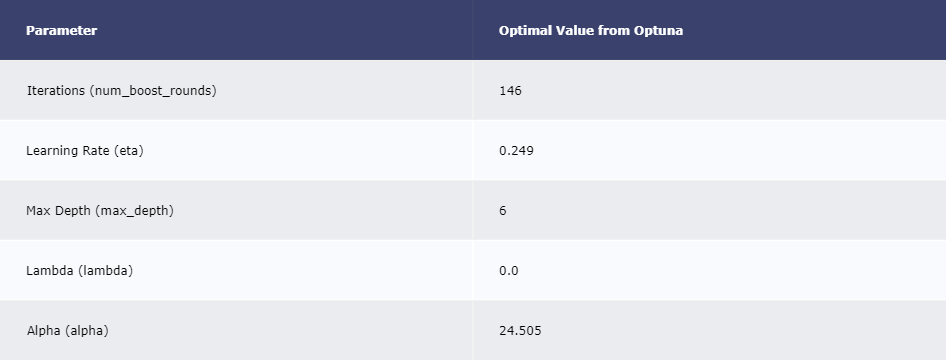

In [17]:
# Now the validaiton set needs lags
# Note the validation set length is one month
df_valid = df_valid.with_columns([
    (df_train.get_column("Vehicles")[-one_month:].alias("Lag_month")),
    (df_train.get_column("Vehicles")[-one_year:(-one_year + one_month)].alias("Lag_year"))
])

# Set up and run the Optuna study
study_xgb_lag = optuna.create_study(direction = 'minimize')
study_xgb_lag.optimize(objective_xgb, n_trials = 10)

# Create a table showing the best parameters
xgb_lag_table = [["Parameter", "Optimal Value from Optuna"],
                 ["Iterations (num_boost_rounds)", study_xgb_lag.best_params['num_boost_round']],
                 ['Learning Rate (eta)', round(study_xgb_lag.best_params['eta'], 3)],
                 ['Max Depth (max_depth)', round(study_xgb_lag.best_params['max_depth'], 3)],
                 ['Lambda (lambda)', round(study_xgb_lag.best_params['lambda'], 3)],
                 ['Alpha (alpha)', round(study_xgb_lag.best_params['alpha'], 3)]]

ff.create_table(xgb_lag_table)

In [18]:
# Taking the model with the best hyperparameters and testing it
xtrain = df_train.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()
xvalid = df_valid.drop(["DateTime", "Junction", "Vehicles"]).to_numpy()

ytrain = df_train.get_column("Vehicles").to_numpy()
yvalid = df_valid.get_column("Vehicles").to_numpy()
    
dmat_train = xgb.DMatrix(xtrain, label = ytrain)
dmat_valid = xgb.DMatrix(xvalid, label = yvalid)

best_params = {'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'seed': 19970507,
                'eta': study_xgb_lag.best_params['eta'],
                'max_depth': study_xgb_lag.best_params['max_depth'],
                'lambda': study_xgb_lag.best_params['lambda'],
                'alpha': study_xgb_lag.best_params['alpha'],
                 }

xgb_lag_model = xgb.train(best_params, 
                         dtrain = dmat_train, 
                         num_boost_round = study_xgb_lag.best_params['num_boost_round'],
                         verbose_eval = False)

xgb_lag_preds_valid = xgb_lag_model.predict(dmat_valid)

print('----------------------------------------------------------')
print('XGBoost (w/ Lagging) validation set RMSE:', math.sqrt(mean_squared_error(yvalid, xgb_lag_preds_valid)))
print('----------------------------------------------------------')

----------------------------------------------------------
XGBoost (w/ Lagging) validation set RMSE: 7.3608118646900005
----------------------------------------------------------


In [19]:
# Initializing a color
xgb_lag_color = '#F7F738'

# Getting the validation data for the plot
df_preds = pl.DataFrame(
    {'DateTime_preds': df_valid.get_column("DateTime"), 
     'Vehicles_preds': xgb_lag_preds_valid, 
     'Group_preds': ["Predictions"]*len(df_valid)}
)

df_xgb_lag_results_valid = (
    pl.concat([df_labels, df_preds], how = 'horizontal')
    .with_columns(
        (pl.lit("True Values").alias("Group_label")),
        (pl.lit("Predictions").alias("Group_pred")))
)

# Plotting the predictions on the validation set
plt_xgb_lag_valid = \
    ggplot(df_xgb_lag_results_valid)+\
    geom_line(aes(x = "DateTime", y = "Vehicles", color = "Group_label"), 
              sampling = "none", size = linesize, show_legend = True)+\
    geom_line(aes(x = "DateTime", y = "Vehicles_preds", color = "Group_pred"), 
              sampling = "none", size = linesize, show_legend = True)+\
    scale_color_manual(values = [true_values_color, xgb_color])+\
    scale_x_datetime(format = "%Y-%m-%d")+\
    scale_y_continuous(limits = [20, 145])+\
    theme_minimal2()+\
    theme(plot_title = element_text(hjust = 0.5, face = 'bold'),
         legend_title = element_blank())+\
    labs(x = "Date", y = "Vehicles", title = "XGBoost (w/ Lagging): Validation Set Predictions")

xgb_lag_bunch = GGBunch()
xgb_lag_bunch.add_plot(plt_xgb_lag_valid, 0, 0, 850, 300)
xgb_lag_bunch

<a id="section-ten"></a>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #F39B9B;
            background-color:#F39B9B;
            overflow:hidden;
            font-weight:500">Conclusion</div>

In this notebook I covered various forecasting models and feature engineering approaches. Note that directly comparing the RMSEs of each method in this notebook should be done with caution due to the limited tuning of the XGBoost models (only 10 Optuna trials each).

If there are any errors in my code, methodology, or if there are any questions please leave a comment.

Thanks for reading!